In [1]:
import scanpy as sc
import numpy as np
import seaborn as sns
import pandas as pd
import time as t
import torch
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import model_selection
import matplotlib.pyplot as plt
from torch.nn.functional import relu
from scipy.stats import norm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

In [4]:
from model_fitting import Fit_tc, Trainer_tc
from model_fitting import Three_states_analytic_model_tc

In [5]:
import pickle
with open('data/names.pickle', 'rb') as f:
    names = pickle.load(f)
with open('data/means.pickle', 'rb') as f:
    means = torch.tensor(pickle.load(f))
with open('data/vars.pickle', 'rb') as f:
    vars = torch.tensor(pickle.load(f))
with open('data/fracs_adj.pickle', 'rb') as f:
    fracs_adj = torch.tensor(pickle.load(f))
with open('data/clusters.pickle', 'rb') as f:
    clusters = torch.tensor(pickle.load(f) )
with open('data/ncells.pickle', 'rb') as f:
    ncells = torch.tensor(pickle.load(f))

In [6]:
log_fracs_adj = torch.log(fracs_adj+torch.tensor(1e-5)).to(default_dtype)
log_means = torch.log(means+torch.tensor(1e-5)).to(default_dtype)
log_vars = torch.log(vars+torch.tensor(1e-5)).to(default_dtype)

In [7]:
fit = Fit_tc(Three_states_analytic_model_tc, n_pts=20, n_genes=500, lr=1e-2)

In [8]:
n=0
fit.trainers[n].train(log_fracs_adj[n], log_means[n], log_vars[n], coef_tc=0.01, N_max=7_000, N_min=7_000, print_=True)

ep: 6999, train: 4.184 in 0.0s  


0.041839112585337415

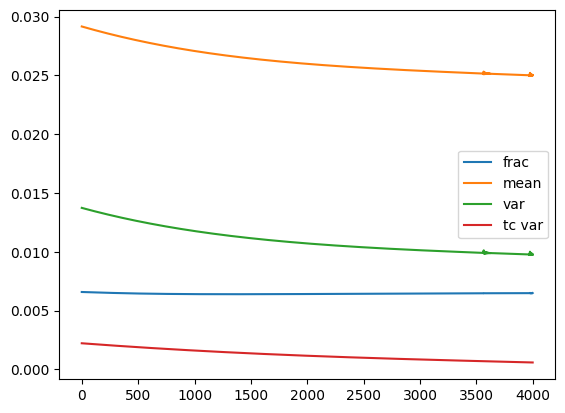

In [9]:
fit.trainers[n].plot(coef_tc=0.01, cut=3_000)

In [10]:
n=0
r_hat = means[n]**2 / (vars[n] - means[n])
r_hat[r_hat < 0] = np.inf
std_mean = np.sqrt(means[n] + means[n]**2 / r_hat) / np.sqrt(ncells)
xerr = 1.96* std_mean

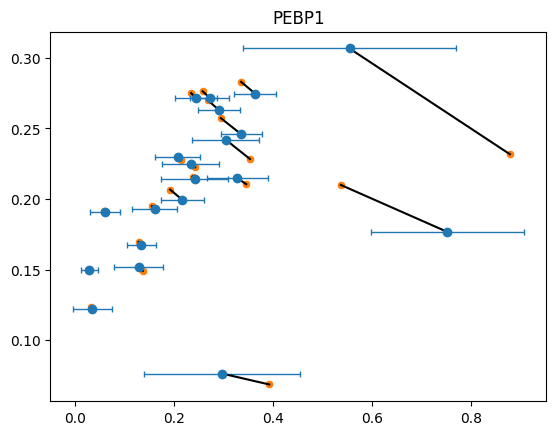

In [11]:
f_, m_, v_, tc_inv = fit.trainers[n].model()
sns.scatterplot(y=fracs_adj[n], x=means[n])
sns.scatterplot(y=f_.detach(), x=m_.detach()).set_title(names[n])
plt.errorbar(y=fracs_adj[n], x=means[n], xerr=xerr, capsize=2, linewidth=1, fmt='o')
for i in range(20):
    ax = sns.lineplot(x=[means[n][i].item(), m_[i].item()], y=[fracs_adj[n][i].item(), f_[i].item()], c='black')

In [12]:
n=2
fit.trainers[n].train(log_fracs_adj[n], log_means[n], log_vars[n], coef_tc=0.01, N_max=7_000, N_min=7_000, print_=True)

ep: 6999, train: 0.733 in 0.0s    


0.007331107747436848

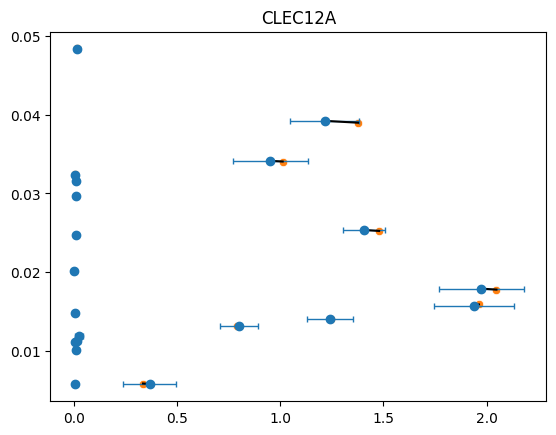

In [13]:
r_hat = means[n]**2 / (vars[n] - means[n])
r_hat[r_hat < 0] = np.inf
std_mean = np.sqrt(means[n] + means[n]**2 / r_hat) / np.sqrt(ncells)
xerr = 1.96* std_mean

f_, m_, v_, tc_inv = fit.trainers[n].model()
sns.scatterplot(y=fracs_adj[n], x=means[n])
sns.scatterplot(y=f_.detach(), x=m_.detach()).set_title(names[n])
plt.errorbar(y=fracs_adj[n], x=means[n], xerr=xerr, capsize=2, linewidth=1, fmt='o')
for i in range(20):
    ax = sns.lineplot(x=[means[n][i].item(), m_[i].item()], y=[fracs_adj[n][i].item(), f_[i].item()], c='black')

In [22]:
fit.train_all(log_fracs_adj, log_means, log_vars, l1_b=0.02, N_max=6000, N_min=1000, print_=False)

100%|█████████████████████████████████████████| 500/500 [38:46<00:00,  4.65s/it]
